# Machine translation

I made this project to get more familiar with NLP and learn something about Machine translation, as well as practice working with torch and torchtext. The ultimate goal was to create a machine translation pipeline, going from raw data to trained algorithm, and adjust it according to currently used data / architecture. This notebook puts all the modules together.

I won't present all the code here. For anyone curious, I encourage you to check out the source code. Set up GPU is assumed.

### Prerequisities

##### Datasets

WMT14
- download https://1drv.ms/f/s!AiQ5a2cXVytTlkZD0HQn5FdGRgB2
- move to data/WMT14

Multi30k
- download https://1drv.ms/f/s!AiQ5a2cXVytTllU4usk93QbPGv1s
- move to data/Multi30k

##### Environment

I highly recommend setting up a conda environment before installing packages.
- navigate to root
- pip install -r requirements.txt

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

from src.data.loader import load_multi30k, load_WMT14
from src.data.raw_to_proc import proc_WMT14, proc_multi30k, create_WMT14_samp
from src.models.lstm_rnn import SimpleEncoder,SimpleEncoderVLS,SimpleDecoder
from src.models.RNN_search import AttnEncoder, AttnDecoder
from src.models import fit,translate

import torch
import torch.nn.functional as F
import torch.optim as optim

d:\programs\anaconda3\envs\machine_translation\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
d:\programs\anaconda3\envs\machine_translation\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
d:\programs\anaconda3\envs\machine_translation\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
d:\programs\anaconda3\envs\machine_translation\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


### Data preprocessing

##### Restructuring

Although the downloads provide both raw and processed datasets, I would like to share functions used on raw data to create the processed data.

In [ ]:
proc_multi30k()
proc_WMT14()
create_WMT14_samp()

##### Accessing data

These functions are used to get access to 3 dataset loaders - WMT14 with batch size 1, Multi30k with batch size 1 and Multi30k with custom batch size (I chose 32). My implementation doesn't support other batch sizes for WMT14. The two variants of Multi30k will be used to showcase certain features of batching when using RNNs.

WMT14 dataset is czech-english, Multi30k is german-english. We are going to translate to english in both cases, hence TRG corresponds to english vocab and SRC corresponds to either czech or german vocab.

In [2]:
train_iter, valid_iter, SRC, TRG = load_WMT14(1)
src, trg = 'src','trg'
ds_name = 'WMT14'

In [3]:
train_iter, valid_iter, SRC, TRG = load_multi30k(1)
src, trg = 'de','en'
ds_name = 'Multi30k'

In [2]:
train_iter, valid_iter, SRC, TRG = load_multi30k(32)
src, trg = 'de','en'
ds_name = 'Multi30k'

Let's set some useful variables too.

In [4]:
n_words_src = len(SRC.vocab)
n_words_trg = len(TRG.vocab)

In [5]:
pad_src_id = SRC.vocab.stoi['<pad>']
pad_trg_id = TRG.vocab.stoi['<pad>']

In [6]:
trg_sos_id = TRG.vocab.stoi['<SOS>']
trg_eos_id = TRG.vocab.stoi['<EOS>']
src_eos_id = SRC.vocab.stoi['<EOS>']

In [7]:
train_len = len(train_iter)
val_len = len(valid_iter)

### Models

##### LSTM RNN

In [22]:
model_name = 'LSTM_RNN'

Setting some basic parameters for network - sizes of embedding vectors and hidden layers.

In [23]:
embedding_size_src = 300
embedding_size_trg = 300

In [24]:
n_hidden_src = 200
n_hidden_trg = 200

This is the most basic type of model we will use. For practical reasons, we are going to treat encoder and decoder separately. The pair below is only capable of single-sequence input processing.

In [10]:
enc = SimpleEncoder(n_words_src,embedding_size_src,n_hidden_src).cuda()
dec = SimpleDecoder(n_words_trg,embedding_size_trg,n_hidden_trg).cuda()

The pair below is able to work with batch of VLS (variable length sequences). Because we are working with RNNs, parallel computation isn't as straightforward as in the case of other architectures, especially in our case with big amount of short sequences of variable lengths. The real dealbreaker here is the fact that we have pairs of sequences, meaning we can't simply join together the ones with least padding. As a solution, I have tried to implement PyTorch PackedSequence objects, with at least some succes. 

In [25]:
enc = SimpleEncoderVLS(n_words_src,embedding_size_src,n_hidden_src,pad_src_id).cuda()
dec = SimpleDecoder(n_words_trg,embedding_size_trg,n_hidden_trg).cuda()

The hyperparameters used can be changed as needed.

##### RNNsearch

In [8]:
model_name = 'RNNsearch'

Here we also need to set some additional parameters - number of layers in encoder / decoder and number of hidden units in alignment network.

In [9]:
embedding_size_src = 300
embedding_size_trg = 300

In [10]:
n_hidden_src = 200
n_hidden_trg = 200

In [11]:
n_layers_src = 1
n_layers_trg = 1

In [12]:
n_allign = 300

In this case, I wasn't able (yet) to come up with a solution for parallel computation of batches of data, so here I only provide model capable of using only one example at a time.

In [13]:
enc = AttnEncoder(n_words_src,embedding_size_src,n_hidden_src,n_layers_src,bidirectional=True).cuda()
dec = AttnDecoder(n_words_trg,embedding_size_trg,n_hidden_trg,n_hidden_src,n_allign,n_layers_trg).cuda()

The hyperparameters used can be changed as needed.

### Training 

##### LSTM RNN

Setting up some training parameters - optimizers, learning rate, loss function, number of epochs

In [11]:
opt_enc = optim.SGD(enc.parameters(),5e-2)
opt_dec = optim.SGD(dec.parameters(),5e-2)
loss_fn = F.nll_loss
epochs = 1

If you haven't gone for VLS model, the first fit function should be used. If using VLS model, the second function should be used. In order to manipulate length of training you can change the end_train and end_val parameters. I suggest using print_every size 5 times smaller than end_train. It's also good idea to set teacher_forcing to zero in the later stages of training

In [12]:
fit.lstm_rnn(enc,dec,train_iter,valid_iter,epochs,opt_enc,opt_dec,loss_fn,n_words_trg, trg_sos_id,
             src, trg, ds_name, model_name, end_train=int(train_len/10),end_val=int(val_len/10),
             print_every=int(train_len/(10*5)))

1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
Train: 5.931363204918285 
Valid: 5.800572688036626 

21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
Train: 5.524714240933409 
Valid: 5.603949924506764 

41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
Train: 5.448665373396166 
Valid: 5.522936438569928 

61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.

In [21]:
fit.lstm_rnn_vls(enc,dec,train_iter,valid_iter,epochs,opt_enc,opt_dec,loss_fn,n_words_trg, trg_sos_id,
                 pad_src_id, pad_trg_id,end_train=int(train_len/5),end_val=int(val_len/5),
                 print_every=int(train_len/(5*5)))

0.6% done
1.1% done
1.7% done
2.2% done
2.8% done
3.3% done
3.9% done
4.4% done
5.0% done
5.5% done
6.1% done
6.6% done
7.2% done
7.7% done
8.3% done
8.8% done
9.4% done
9.9% done
10.5% done
11.0% done
11.6% done
12.2% done
12.7% done
13.3% done
13.8% done
14.4% done
14.9% done
15.5% done
16.0% done
16.6% done
17.1% done
17.7% done
18.2% done
18.8% done
19.3% done
19.9% done
Train: 5.073108215524693 
Valid: 5.1813329735187565 

20.4% done
21.0% done
21.5% done
22.1% done
22.7% done
23.2% done
23.8% done
24.3% done
24.9% done
25.4% done
26.0% done
26.5% done
27.1% done
27.6% done
28.2% done
28.7% done
29.3% done
29.8% done
30.4% done
30.9% done
31.5% done
32.0% done
32.6% done
33.1% done
33.7% done
34.3% done
34.8% done
35.4% done
35.9% done
36.5% done
37.0% done
37.6% done
38.1% done
38.7% done
39.2% done
39.8% done
Train: 5.2609340686990755 
Valid: 5.150072846749817 

40.3% done
40.9% done
41.4% done
42.0% done
42.5% done
43.1% done
43.6% done
44.2% done
44.8% done
45.3% done
45.9% do

Fit functions automatically save progress along with printing losses (see source code of fit functions), but these functions can be used to manually save / load models.

In [26]:
model_path_Multi30k = 'models/LSTM_RNN/Multi30k/'
model_path_WMT14 = 'models/LSTM_RNN/WMT14/'

Loading / saving Multi30k models

In [27]:
enc.load_state_dict(torch.load(f'{model_path_Multi30k}enc.pt'))
dec.load_state_dict(torch.load(f'{model_path_Multi30k}dec.pt'))

In [ ]:
torch.save(enc.state_dict(), f'{model_path_Multi30k}enc.pt')
torch.save(dec.state_dict(), f'{model_path_Multi30k}dec.pt')

Loading / saving WMT14 models

In [18]:
enc.load_state_dict(torch.load(f'{model_path_WMT14}enc.pt'))
dec.load_state_dict(torch.load(f'{model_path_WMT14}dec.pt'))

In [17]:
torch.save(enc.state_dict(), f'{model_path_WMT14}enc.pt')
torch.save(dec.state_dict(), f'{model_path_WMT14}dec.pt')

Example of loading 3rd iteration of Multi30k model.

In [15]:
enc.load_state_dict(torch.load(f'{model_path_Multi30k}enc_3.pt'))
dec.load_state_dict(torch.load(f'{model_path_Multi30k}dec_3.pt'))

##### RNNsearch

Setting up some training parameters - optimizers, learning rate, loss function, number of epochs

In [14]:
opt_enc = optim.SGD(enc.parameters(),5e-2)
opt_dec = optim.SGD(dec.parameters(),5e-2)
loss_fn = F.nll_loss
epochs = 3

These parameters serve for selecting an amount of data to go through each epoch (it's convenient to use fractions of original length). Some additional parameters can also be found - number of (moving) losses to plot and saving frequency. Role of batch size and teacher forcing should be obvious (attention - the batch size here refers to number of gradients computed before updating weights, not parallel computation).

In [15]:
end_train = int(train_len/50)
end_val = int(val_len/20)
plot_every = int(train_len/(50*30))
save_every = int(train_len/(50*3))
batch_size = 16
teacher_forcing = 0.5


Train: 5.874193363189697 
Valid: 6.028426399230957



Train: 5.686587276458741 
Valid: 5.912645969390869



Train: 5.627007794380188 
Valid: 5.464994306564331


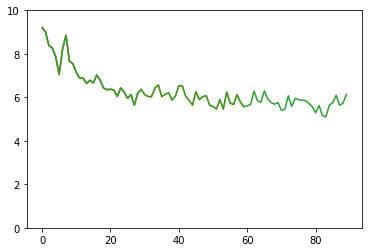

In [16]:
fit.rnnsearch(enc, dec, train_iter, valid_iter, epochs, opt_enc, opt_dec, loss_fn, n_words_trg, 
              teacher_forcing, end_train, end_val, plot_every, save_every, batch_size)

It's a good idea to do a second round of training with adjusted parameters.

In [17]:
opt_enc = optim.SGD(enc.parameters(),5e-3)
opt_dec = optim.SGD(dec.parameters(),5e-3)
loss_fn = F.nll_loss
epochs = 3

In [18]:
end_train = int(train_len/100)
end_val = int(val_len/20)
plot_every = int(train_len/(100*30))
save_every = int(train_len/(100*3))
batch_size = 16
teacher_forcing = 0


Train: 5.637385234832764 
Valid: 5.345147037506104



Train: 5.4817650032043455 
Valid: 5.495782470703125



Train: 5.46982970237732 
Valid: 5.7603433275222775


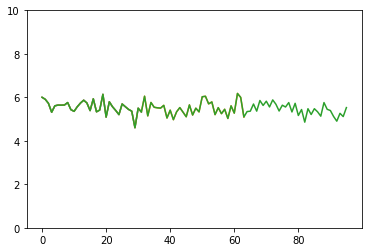

In [19]:
fit.rnnsearch(enc, dec, train_iter, valid_iter, epochs, opt_enc, opt_dec, loss_fn, n_words_trg, 
              teacher_forcing, end_train, end_val, plot_every, save_every, batch_size)

Well, this seems pretty bad for a model that should have outperformed lstm rnn. See more in analysis

Loading trained models

In [20]:
model_path_Multi30k = 'models/RNNsearch/Multi30k/'
model_path_WMT14 = 'models/RNNsearch/WMT14/'

Loading / saving Multi30k models

In [11]:
enc.load_state_dict(torch.load(f'{model_path_Multi30k}enc.pt'))
dec.load_state_dict(torch.load(f'{model_path_Multi30k}dec.pt'))

In [21]:
torch.save(enc.state_dict(), f'{model_path_Multi30k}enc.pt')
torch.save(dec.state_dict(), f'{model_path_Multi30k}dec.pt')

### Analysis

We won't dig deep into the model's workings / performance. For now, we will only look at examples of the model's translations. This will give us some insight into it's capabilities and we will also be able to better interpret the results given by applying custom metric.

To get new example, simply reload the line below. 

In [28]:
rand_ex = next(iter(valid_iter))
ex_src,ex_trg = getattr(rand_ex,src),getattr(rand_ex,trg)

These two cells show what we are going to translate and it's human translation.

In [29]:
[SRC.vocab.itos[x] for x in ex_src[:,0]]

['ein',
 'mann',
 'und',
 'zwei',
 'kinder',
 'überqueren',
 'eine',
 'straße',
 '<EOS>']

In [30]:
[TRG.vocab.itos[x] for x in ex_trg[:,0]]

['<SOS>',
 'a',
 'man',
 'and',
 'two',
 'children',
 'crossing',
 'a',
 'street',
 '<EOS>']

##### LSTM RNN

Here we use our model to translate the sentence. Choose appropriate translate function (Multi30k, Multi30k_VLS and WMT14 respectively).

In [42]:
sent_ids = translate.Multi30k(enc,dec,trg_sos_id,trg_eos_id,ex_src)

In [31]:
sent_ids = translate.Multi30k_VLS(enc,dec,trg_sos_id,trg_eos_id,pad_src_id,ex_src[:,0][:,None])

In [22]:
sent_ids = translate.WMT14(enc,dec,trg_sos_id,trg_eos_id,ex_src)

Now we can take a look at the sentence our model created.

In [32]:
[TRG.vocab.itos[x] for x in sent_ids]

['a',
 'man',
 'and',
 'two',
 'children',
 'are',
 'in',
 'the',
 'street',
 'street',
 '<EOS>']

Well, that isn't perfect and we have to acknowledge that the dataset represents only narrow domain of natural language, but given how minimalistic our model is, this seems pretty impressive!

##### RNNsearch

In [23]:
sent_ids = translate.rnnsearch(enc, dec, trg_sos_id, trg_eos_id, ex_src)

Here is the resulting sequence.

In [24]:
[TRG.vocab.itos[x] for x in sent_ids]

['a', '<EOS>']

This isn't really acceptable. I am going to try and fix this, so the model will be able to perform better.